# 📝 **Code History**

---

📅 Date: 2025-10-02
👤 Author: Enrico Biscaro
🔢 **Version: 1.1**

- 🔍 Replaced multiple `if 'd17O' in picarro_sample.columns` checks with a more robust condition: `standard['d17O_real'].notnull().all()`. This ensures the column not only exists but also contains exclusively valid (non-null) data, significantly improving the reliability and accuracy of the data validation process.
- 🎨 Refined and fixed various aesthetic issues in the `regression.py` plotting function, enhancing the visual appeal and clarity of the generated graphs.


---


> # ✏️ **1. Enter your inputs**  
📝 Follow these steps before running the script:


> 1️⃣ **Step 1: Set the file name**  
> 🖥️ Set the **`file_name`** to the directory of the raw Picarro data file *(including the file extension `.csv`)*.

> 2️⃣ **Step 2: Set the  last injection to consider**  
> 💉 **`last_inj_considered`**: set this to the number of the last injection used to calculate the mean, usually **3**. Change only if necessary.

🚨 **Important:** *Unless instructed otherwise, you only need to set `file_name` and leave `last_inj_considered` as it is!*

> 3️⃣  **Step 3: Run the Cell**  
> ▶️ **Run the cell** after making these changes to apply them.



In [1]:
file_name = "/home/enricobiscaro/Documents/PhD/Tools/Picarro/Calibration/HKDS2177_IsoWater_20251110_092337.csv"
last_inj_considered = 3

> # **2. Importing Libraries and Functions 📚**  
> ▶️ **Run the cell** below to import all the necessary libraries and functions—**no changes needed!**  


In [2]:
import pandas as pd
import numpy as np 
import time
import os 
import statsmodels.api as sm

from plotly.subplots import make_subplots
import plotly.graph_objs as go

import base64
from openpyxl.styles import Border

from detectOutliersMAD import detect_outliers_mad
from listOutliers import list_outliers 
from outliersRule import outliers_rule
from outliersPlot import outliers_plot_stdev
from regression import regression
from calculateStandard import calculate_standard_cal

> # **3. Defining true values of standards** 📏
> ▶️ **Run the cell** below to import the $\delta^{18}O$, $\delta^{17}O$, $\Delta^{17}O$ and $\delta^{2}H$  real value!

In [3]:
d18O_values = {
    "MSW": 1.0173, "CAL": -5.0934, "VE": -8.8913, "NS": -15.45,
    "NVL": -31.0760, "TD": -38.36, "DCS": -51.9095, "AP1": -54.4950,
    "VSMOW": 0, "SLAP": -55.50, "GRESP": -33.4, "UIB": -41.83, "VDC": -52.40,
    "LSCE": -61.05, "AWI_NOV": -49.15, "AWI_JAN": -49.0238
}

dD_values = {
    "MSW": 6.0, "CAL": -33.3, "VE": -58.9, "NS": -113.4, "NVL": -239.0,
    "TD": -304.9, "DCS": -407.2, "AP1": -423.8, "VSMOW": 0, "SLAP": -427.5,
    "GRESP": -258, "UIB": -322.29, "VDC": -407.13, "LSCE": -475.04, "AWI_NOV": -383.67,
    "AWI_JAN": -328.7
}

d17O_values = {
    "MSW": 0.5297, "CAL": None, "VE": -4.6779, "NS": -8.1515, "NVL": -16.5949,
    "TD": None, "DCS": -27.7286, "AP1": None, "VSMOW": 0, "SLAP": None, "GRESP": None,
    "UIB": -22.2854, "VDC": -28.0099, "LSCE": -32.6996, "AWI_NOV": -26.2509, "AWI_JAN": -26.1826
}

D17O_values = {
    "MSW": -7, "CAL": None, "VE": 27, "NS": 34, "NVL": -66, "TD": None,
    "DCS": 25, "AP1": None, "VSMOW": 0, "SLAP": None, "GRESP": None, "UIB": 15,
    "VDC": 4, "LSCE": 14, "AWI_NOV": 8, "AWI_JAN": 9
}

# **4. Calibrating Picarro2130 or Picarro2140 run** 🛠️

### **4.1. Searching missed injections** 🔴💉
> ▶️ **Run the cell** below to identify missed and skipped injection inside the run!

> 💡 If any missed or skipped injections are detected, a ⚠️ warning message will be displayed. Otherwise, a ✅ confirmation message will indicate that everything is okay.


In [4]:
picarro_df = pd.read_csv(file_name, skipinitialspace=True).rename(columns=lambda x: x.replace(' ', ''))
picarro_df['vial'] = picarro_df.groupby('Analysis').ngroup() + 1
picarro_df['Notes'] = None

counter = 0
added_rows = []
print('⏳ Searching for skipped injections...')
for i in range(len(picarro_df)-1):
    index = picarro_df['Line'].iloc[i]
    if picarro_df['Line'].iloc[i+1] != (index + 1):
        follow_inj_nr = picarro_df['InjNr'].iloc[i] + 1
        if follow_inj_nr >= 9:
            follow_inj_nr = 1
        new_row = pd.Series({'Identifier': picarro_df['Identifier1'].iloc[i], 'Type' : picarro_df['Identifier2'].iloc[i],  'Injection number': follow_inj_nr,
                            'Line': index + 1, 'Analysis': picarro_df['Analysis'].iloc[i], 'Notes': 'Skipped'})
        picarro_df = pd.concat([picarro_df.iloc[:i+1], new_row.to_frame().T, picarro_df.iloc[i+1:]], ignore_index=True)
        counter = counter + 1
        added_rows.append(new_row)
if counter > 0 :
    print(f'''⚠️ Warning!: skipped {counter} injections identified. A blank line will be added for each one! 📝
        ''')
    added_rows_df = pd.DataFrame(added_rows)
    display(added_rows_df[['Identifier','Type','Injection number']])
else:
   print('''✅ No skipped injections found! Keep going! 🚀
   ''')


picarro_raw = picarro_df
picarro_df = picarro_df.groupby('Analysis').tail(last_inj_considered)
print('''
⏳ Searching for missed injections...''')
time.sleep(1)

check = False
if picarro_df['d(18_16)Mean'].isna().sum() > 0:
    flag_na = np.where(picarro_df['d(18_16)Mean'].isna())
    flag_na = flag_na[0]
    missed_injection_Identifier2 = []
    missed_injection_Identifier1 = []
    missed_injection_number = []
    missed_injection_notes = []
    for i in flag_na:
        missed_injection_Identifier2.append(picarro_df['Identifier2'].iloc[i])
        missed_injection_Identifier1.append(picarro_df['Identifier1'].iloc[i])
        missed_injection_number.append(picarro_df['InjNr'].iloc[i])
        missed_injection_notes.append(picarro_df['Notes'].iloc[i])
        missed_injection = pd.DataFrame([missed_injection_Identifier1,missed_injection_Identifier2,missed_injection_number, missed_injection_notes]).transpose()
        missed_injection.columns = ['Identifier','Type','Injection number', 'Notes']
        missed_injection = missed_injection[missed_injection['Notes'] != 'Skipped']
    if not missed_injection.empty:
        print("⚠️ Warning: the following analysis contains NaN values, which may indicate missing injections ⚠️")
        display(missed_injection)
    elif missed_injection.empty and check == False:
        check = True
        print('✅ No missed injections found! Keep going! 🚀')
elif picarro_df['d(18_16)Mean'].isna().sum() == 0 and check == False:
  print('✅ No missed injections found! Keep going! 🚀')

⏳ Searching for skipped injections...
✅ No skipped injections found! Keep going! 🚀
   

⏳ Searching for missed injections...
✅ No missed injections found! Keep going! 🚀


### **4.2. Detecting outliers for $\delta^{18}O$ and $\delta^{2}H$ 📈**
  > ▶️ **Run the cell** and if any outliers are detected, a ⚠️ warning message will be displayed. Additionally, a pop-up will appear asking if you'd like to visualize the graph of the detected outliers. Otherwise, a ✅ confirmation message will indicate that everything is okay.

In [5]:
out_d18O  = list_outliers(picarro_df, picarro_raw, 'd(18_16)Mean', 3.5, r'$\delta^{18}O$ [‰]')
out_dD = list_outliers(picarro_df, picarro_raw, 'd(D_H)Mean', 5, r'$\delta^{2}H$ [‰]')
if 'd(17_16)Mean' in picarro_df.columns:
    out_d17O  = list_outliers(picarro_df, picarro_raw, 'd(17_16)Mean', 3.5, r'$\delta^{17}O$ [‰]')

🛑 Outliers detected for oxygen-18! 🛑


,Analysis,Identifier,Type,Injection Number,Line
0,P-12651,UIB,BUFFER,7,7
1,P-12655,LSCE,BUFFER,6,38
2,P-12656,LSCE,STD,7,47
3,P-12668,BE_LDC_2405_HighRes_33,BUFFER,6,142
4,P-12669,BE_LDC_2405_HighRes_33,SAMPLE,6,150
5,P-12670,BE_LDC_2405_HighRes_34,SAMPLE,8,160
6,P-12671,BE_LDC_2405_HighRes_35,SAMPLE,8,168
7,P-12673,BE_LDC_2405_HighRes_37,SAMPLE,6,182


🛑 Outliers detected for hydrogen! 🛑


,Analysis,Identifier,Type,Injection Number,Line
0,P-12658,VDC,SPY,6,62
1,P-12674,BE_LDC_2405_HighRes_38,SAMPLE,6,190


> ▶️ Run the cell to visualize a graph for vials where the standard deviation for oxygen is greater than 0.05 or for hydrogen is greater than 0.2 in the last three injections. If you want you can easily modify the threshold in the cell below.

In [6]:
if 'd(17_16)Mean' in picarro_df.columns:
  check_out_std = picarro_df.groupby('Analysis', observed=True)[['d(18_16)Mean','d(D_H)Mean', 'd(17_16)Mean']].transform('std')
  picarro_df_copy = picarro_df.copy()
  picarro_df_copy[['d(18_16)Mean_std', 'd(D_H)Mean_std', 'd(17_16)Mean_std']] = check_out_std
  out_stdev = picarro_df_copy[['Analysis','Identifier1', 'Identifier2', 'InjNr','d(18_16)Mean', 'd(D_H)Mean', 'd(17_16)Mean', 'd(18_16)Mean_std', 'd(D_H)Mean_std', 'd(17_16)Mean_std', 'Line']].rename(columns={'Analysis': 'Analysis', 'Identifier1': 'Identifier', 'Identifier2': 'Type', 'InjNr': 'Injection Number', 'd(18_16)Mean': 'd18O', 'd(D_H)Mean': 'dD', 'd(18_16)Mean_std': 'd18O_STD', 'd(D_H)Mean_std': 'dD_STD', 'd(17_16)Mean_std': 'd17O_STD', 'Line': 'Code to remove'}).set_index('Code to remove')

else:
  check_out_std = picarro_df.groupby('Analysis', observed=True)[['d(18_16)Mean','d(D_H)Mean']].transform('std')
  picarro_df_copy = picarro_df.copy()
  picarro_df_copy[['d(18_16)Mean_std', 'd(D_H)Mean_std']] = check_out_std
  out_stdev = picarro_df_copy[['Analysis','Identifier1', 'Identifier2', 'InjNr','d(18_16)Mean', 'd(D_H)Mean', 'd(18_16)Mean_std', 'd(D_H)Mean_std', 'Line']].rename(columns={'Analysis': 'Analysis', 'Identifier1': 'Identifier', 'Identifier2': 'Type', 'InjNr': 'Injection Number', 'd(18_16)Mean': 'd18O', 'd(D_H)Mean': 'dD', 'd(18_16)Mean_std': 'd18O_STD', 'd(D_H)Mean_std': 'dD_STD', 'Line': 'Code to remove'}).set_index('Code to remove')

out_stdev_18O = out_stdev[(out_stdev['d18O_STD']>0.05)].reset_index()
unique_analyses_18O = out_stdev_18O['Analysis'].unique()
outliers_plot_stdev(picarro_raw,unique_analyses_18O,'d(18_16)Mean', r'$\delta^{18}O$ [‰]')

out_stdev_D = out_stdev[(out_stdev['dD_STD']>0.2)].reset_index()
unique_analyses_D = out_stdev_D['Analysis'].unique()
outliers_plot_stdev(picarro_raw,unique_analyses_D,'d(D_H)Mean',r'$\delta^{2}H$ [‰]')

if 'd(17_16)Mean' in picarro_df.columns:
  out_stdev_17O = out_stdev[(out_stdev['d17O_STD']>0.02)].reset_index()
  unique_analyses_17O = out_stdev_17O['Analysis'].unique()
  outliers_plot_stdev(picarro_raw,unique_analyses_17O,'d(17_16)Mean', r'$\delta^{17}O$ [‰]')

✅ No outliers identified for oxygen! 🏞️ Keep going! 🚙
            
🛑 Warning: For the last 3 injections, a standard deviation greater than 0.2 was found for hydrogen! 🛑


### **📋 4.3. Defining outliers to remove**

▶️ **Run the cell** and select which outliers you want to remove. A step-by-step process will guide you. Specifically, three main options are available. First, you can automatically remove all the outliers that the system has identified 🗑️. Second, you can choose to keep all the outliers in the data without removing any. Third, you can manually select which outliers (for both oxygen and hydrogen) you want to remove. To do this, you simply need to provide a list of the outliers you want to remove, separating the numbers with commas. For example, if you want to remove the outliers with numbers 1, 3, and 5, you would enter `1, 3, 5`.


In [7]:

picarro_df = pd.read_csv(file_name, skipinitialspace=True).rename(columns=lambda x: x.replace(' ', ''))
picarro_df.loc[:, 'vial'] = picarro_df.groupby('Analysis').ngroup() + 1

picarro_df = picarro_df.groupby('Analysis').tail(last_inj_considered)

if 'd(17_16)Mean' in picarro_df.columns:
  removed_outlier =  outliers_rule(picarro_df,out_dD, out_d18O, out_d17O)
else:
  removed_outlier =  outliers_rule(picarro_df,out_dD, out_d18O, None)


if 'd(17_16)Mean' in picarro_df.columns:
    check_out_std = picarro_df.groupby('Analysis')[['d(18_16)Mean','d(D_H)Mean', 'd(17_16)Mean']].transform('std')
    picarro_df[['d(18_16)Mean_std', 'd(D_H)Mean_std', 'd(17_16)Mean_std']] = check_out_std
    display(picarro_df[['Identifier1', 'Identifier2', 'InjNr','d(18_16)Mean', 'd(D_H)Mean', 'd(17_16)Mean', 'd(18_16)Mean_std', 'd(D_H)Mean_std', 'd(17_16)Mean_std', 'Line']].rename(columns={'Identifier1': 'Identifier', 'Identifier2': 'Type', 'InjNr': 'Injection Number', 'd(18_16)Mean': 'd18O', 'd(D_H)Mean': 'dD', 'd(17_16)Mean': 'd17O', 'd(18_16)Mean_std': 'd18O_STD', 'd(D_H)Mean_std': 'dD_STD', 'd(17_16)Mean_std': 'd17O_STD', 'Line': 'Code to remove'}).set_index('Code to remove'))
    values_to_extract = removed_outlier['Removed outlier oxygen-17'].dropna().unique()
    removed_inj_oxygen_17 = picarro_raw[picarro_raw['Line'].isin(values_to_extract)]
else:
  check_out_std = picarro_df.groupby('Analysis')[['d(18_16)Mean','d(D_H)Mean']].transform('std')
  picarro_df[['d(18_16)Mean_std', 'd(D_H)Mean_std']] = check_out_std
  display(picarro_df[['Identifier1', 'Identifier2', 'InjNr','d(18_16)Mean', 'd(D_H)Mean', 'd(18_16)Mean_std', 'd(D_H)Mean_std', 'Line']].rename(columns={'Identifier1': 'Identifier', 'Identifier2': 'Type', 'InjNr': 'Injection Number', 'd(18_16)Mean': 'd18O', 'd(D_H)Mean': 'dD', 'd(18_16)Mean_std': 'd18O_STD', 'd(D_H)Mean_std': 'dD_STD', 'Line': 'Code to remove'}).set_index('Code to remove'))

values_to_extract = removed_outlier['Removed outlier oxygen-18'].dropna().unique()
removed_inj_oxygen = picarro_raw[picarro_raw['Line'].isin(values_to_extract)]
values_to_extract = removed_outlier['Removed outlier hydrogen'].dropna().unique()
removed_inj_hydrogen = picarro_raw[picarro_raw['Line'].isin(values_to_extract)]

✅ No outliers have been delated! 


,Identifier,Type,Injection Number,d18O,dD,d18O_STD,dD_STD
Code to remove,,,,,,,
6,UIB,BUFFER,6,-43.445,-337.395,0.008963,0.108795
7,UIB,BUFFER,7,-43.429,-337.608,0.008963,0.108795
8,UIB,BUFFER,8,-43.444,-337.540,0.008963,0.108795
14,UIB,BUFFER,6,-43.447,-337.583,0.008083,0.008505
15,UIB,BUFFER,7,-43.441,-337.599,0.008083,0.008505
...,...,...,...,...,...,...,...
247,LSCE,BUFFER,7,-62.546,-486.053,0.006506,0.078689
248,LSCE,BUFFER,8,-62.533,-485.993,0.006506,0.078689
254,LSCE,STD,6,-62.553,-486.187,0.003606,0.055293


### **4.4. Calibrating data** 🔧

▶️ **Run the cell** to calibrate the data

#### 4.4.1. Select only the necessary columns

In [8]:
if 'd(17_16)Mean' in picarro_df.columns:
    picarro = picarro_df.groupby(["Analysis", "Identifier1", "Identifier2"]).agg(
        d18O =pd.NamedAgg(column="d(18_16)Mean", aggfunc="mean"),
        STD_d18O=pd.NamedAgg(column="d(18_16)Mean", aggfunc="std"),
        dD=pd.NamedAgg(column="d(D_H)Mean", aggfunc="mean"),
        STD_dD =pd.NamedAgg(column="d(D_H)Mean", aggfunc="std"),
        d17O =pd.NamedAgg(column="d(17_16)Mean", aggfunc="mean"),
        STD_d17O=pd.NamedAgg(column="d(17_16)Mean", aggfunc="std") ).reset_index()

else:
    picarro = picarro_df.groupby(["Analysis", "Identifier1", "Identifier2"]).agg(
        d18O =pd.NamedAgg(column="d(18_16)Mean", aggfunc="mean"),
        STD_d18O =pd.NamedAgg(column="d(18_16)Mean", aggfunc="std"),
        dD=pd.NamedAgg(column="d(D_H)Mean", aggfunc="mean"),
        STD_dD =pd.NamedAgg(column="d(D_H)Mean", aggfunc="std")).reset_index()

picarro = picarro.rename(columns={'Identifier1': 'Sample', 'Identifier2': 'ID'})
display(picarro)

,Analysis,Sample,ID,d18O,STD_d18O,dD,STD_dD
0,P-12651,UIB,BUFFER,-43.439333,0.008963,-337.514333,0.108795
1,P-12652,UIB,BUFFER,-43.439667,0.008083,-337.589333,0.008505
2,P-12653,UIB,STD,-43.447667,0.013051,-337.551667,0.011504
3,P-12654,LSCE,BUFFER,-62.461000,0.017521,-484.960000,0.214063
4,P-12655,LSCE,BUFFER,-62.534333,0.009866,-485.781667,0.045742
5,P-12656,LSCE,STD,-62.564000,0.026963,-486.117667,0.053257
6,P-12657,VDC,BUFFER,-54.146000,0.015524,-421.372667,0.107500
7,P-12658,VDC,SPY,-54.127667,0.002517,-421.135000,0.019975
8,P-12659,BE_LDC_2405_HighRes_27,BUFFER,-54.389000,0.016823,-427.391667,0.006429
9,P-12660,BE_LDC_2405_HighRes_27,SAMPLE,-54.395000,0.012530,-427.404333,0.022030


#### 4.4.2. Select the correct standard (STD)

In [9]:
standard_found = picarro[(picarro['ID'].astype(str).str.strip().str.upper() == 'STD') |
                        (picarro['ID'].astype(str).str.strip().str.upper() == 'STANDARD')]
unique_samples = standard_found['Sample'].unique()

for i, sample in enumerate(unique_samples, 1):
    var_name = sample.replace(" ", "_").replace("-", "_")
    globals()[f"std_{i}"] = sample

d18O_real = []
dD_real = []
d17O_real = []
D17O_real = []

for i in range(1, len(unique_samples) + 1):
    key = unique_samples[i - 1]
    globals()[f'd18O_real_{i}'] = d18O_values.get(key, None)
    globals()[f'dD_real_{i}'] = dD_values.get(key, None)
    d18O_real.append(globals()[f'd18O_real_{i}'])
    dD_real.append(globals()[f'dD_real_{i}'])

    if 'd(17_16)Mean' in picarro_df.columns:
        globals()[f'd17O_real_{i}'] = d17O_values.get(key, None)
        globals()[f'D17O_real_{i}'] = D17O_values.get(key, None)
        d17O_real.append(globals()[f'd17O_real_{i}'])
        D17O_real.append(globals()[f'D17O_real_{i}'])

print('📏📊 Standard compliance 📊📏')

if 'd(17_16)Mean' in picarro_df.columns:
    display(standard_found.round({'d18O': 2, 'STD_d18O': 2, 'dD': 2, 'STD_dD': 2, 'd17O': 2, 'STD_d17O': 2}))
else: 
    display(standard_found.round({'d18O': 2, 'STD_d18O': 2, 'dD': 2, 'STD_dD': 2}))

📏📊 Standard compliance 📊📏


,Analysis,Sample,ID,d18O,STD_d18O,dD,STD_dD
2,P-12653,UIB,STD,-43.45,0.01,-337.55,0.01
5,P-12656,LSCE,STD,-62.56,0.03,-486.12,0.05
28,P-12679,UIB,STD,-43.45,0.01,-337.91,0.02
31,P-12682,LSCE,STD,-62.55,0.00,-486.25,0.06


#### 4.4.3. Select the correct Quality Control (SPY)

In [10]:
QC_found = picarro[(picarro['ID'].astype(str).str.strip().str.upper() == 'QC')|
                (picarro['ID'].astype(str).str.strip().str.upper() == 'SPY')]

print('📏📊  Quality Control compliance 📊📏')
if 'd(17_16)Mean' in picarro_df.columns:
    display(QC_found.round({'d18O': 2, 'STD_d18O': 2, 'dD': 2, 'STD_dD': 2, 'd17O': 2, 'STD_d17O': 2}))
else: 
    display(QC_found.round({'d18O': 2, 'STD_d18O': 2, 'dD': 2, 'STD_dD': 2}))

📏📊  Quality Control compliance 📊📏


,Analysis,Sample,ID,d18O,STD_d18O,dD,STD_dD
7,P-12658,VDC,SPY,-54.13,0.00,-421.14,0.02
16,P-12667,AWI_NOV,SPY,-50.88,0.01,-398.34,0.04


### 4.4.4. Performing linear regression

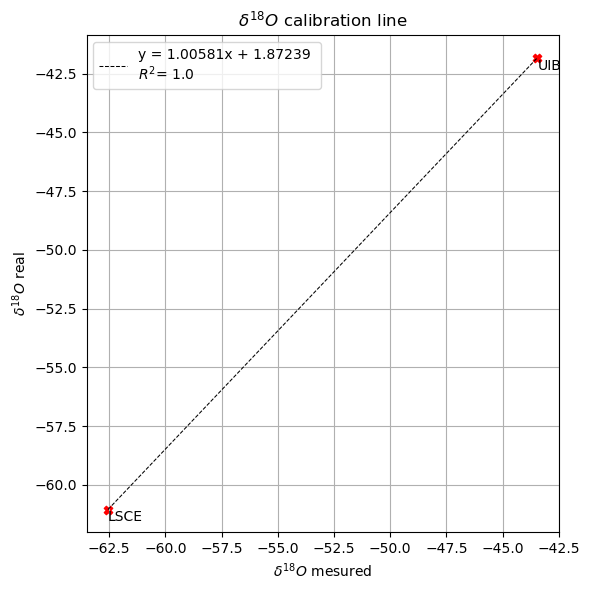

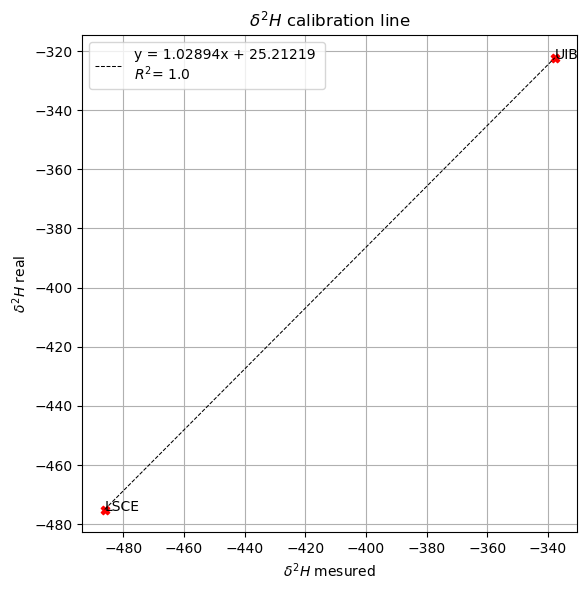

In [11]:
standard = picarro[(picarro['ID'].astype(str).str.strip().str.upper() == 'STD' )|
                    (picarro['ID'].astype(str).str.strip().str.upper() == 'STANDARD' )]
            
standard = standard.copy()
standard['idx'] = pd.factorize(standard['Sample'])[0] + 1

if 'd(17_16)Mean' in picarro_df.columns:
    standard = standard.groupby(['idx','Sample'])[['d18O','dD','d17O']].agg('mean')
    standard['d18O_real'] = d18O_real
    standard['dD_real'] = dD_real
    standard['d17O_real'] = d17O_real
    standard['D17O_real'] = D17O_real
else: 
    standard = standard.groupby('Sample', sort=False)[['d18O','dD']].agg('mean')
    standard['d18O_real'] = d18O_real
    standard['dD_real'] = dD_real

d_18O_reg = regression(standard,'d18O','d18O_real',r'$\delta^{18}O$ calibration line', r'$\delta^{18}O$ mesured',  r'$\delta^{18}O$ real', standard)
d_D_reg =  regression(standard, 'dD','dD_real',r'$\delta^{2}H$ calibration line', r'$\delta^{2}H$ mesured',  r'$\delta^{2}H$ real', standard)

if 'd(17_16)Mean' in picarro_df.columns and standard['d17O_real'].notnull().all():
    d17O_reg = regression(standard, 'd17O','d17O_real',r'$\delta^{17}O$ calibration line', r'$\delta^{17}O$ mesured',  r'$\delta^{17}O$ real', standard)
    regression_results = pd.DataFrame({
        'Measurement': ['d18O', 'dD', 'd17O'],
        'Slope': [d_18O_reg[0], d_D_reg[0], d17O_reg[0]],
        'Intercept': [d_18O_reg[1], d_D_reg[1], d17O_reg[1]]
    })
else: 
    regression_results = pd.DataFrame({
        'Measurement': ['d18O', 'dD'],
        'Slope': [d_18O_reg[0], d_D_reg[0]],
        'Intercept': [d_18O_reg[1], d_D_reg[1]]
    })

#### 4.4.5. Calculating the calibrated values

In [12]:
import numpy as np 
import os 

picarro["d18O_cal"] = picarro["d18O"] * regression_results["Slope"].iloc[0] + regression_results['Intercept'].iloc[0]
picarro["dD_cal"] = picarro["dD"] * regression_results["Slope"].iloc[1] + regression_results['Intercept'].iloc[1]
            
if 'd(17_16)Mean' in picarro_df.columns and standard['d17O_real'].notnull().all():
    picarro["d17O_cal"] = picarro["d17O"] * regression_results["Slope"].iloc[2] + regression_results['Intercept'].iloc[2]
    picarro["D17O_cal"] = 1000000 * (np.log(picarro["d17O_cal"]/1000 + 1) - 0.528 * np.log(picarro["d18O_cal"]/1000 + 1))
    
picarro_sample = picarro[picarro["ID"].astype(str).str.strip().str.upper() == 'SAMPLE']   

if not QC_found.empty:
    picarro_QC = picarro[(picarro['ID'].str.strip().str.upper() == 'QC')|
                            (picarro['ID'].str.strip().str.upper() == 'SPY')]
    picarro_QC = picarro_QC.copy().reset_index()
    for i in range(len(picarro_QC)):
        ID = picarro_QC['Sample'].iloc[i]
        picarro_QC.loc[i, "d18O_real"] = d18O_values.get(ID, None)
        picarro_QC.loc[i, "dD_real"] = dD_values.get(ID, None)
        if 'd(17_16)Mean' in picarro_df.columns:
            picarro_QC.loc[i, "d17O_real"] = d17O_values.get(ID, None)
            picarro_QC.loc[i, "D17O_real"] = D17O_values.get(ID, None)

    picarro_QC['d18O_diff'] = (picarro_QC['d18O_cal'] - picarro_QC['d18O_real'])
    picarro_QC['dD_diff'] = (picarro_QC['dD_cal'] - picarro_QC['dD_real'])

if 'd(17_16)Mean' in picarro_df.columns and not QC_found.empty:
    picarro_QC["d17O_cal"] = picarro_QC["d17O"] * regression_results["Slope"].iloc[2] + regression_results['Intercept'].iloc[2]
    picarro_QC['d17O_diff'] = (picarro_QC['d17O_cal'] - picarro_QC['d17O_real'])
    picarro_QC['D17O_diff'] = (picarro_QC['D17O_cal'] - picarro_QC['D17O_real'] )
     

if 'd(17_16)Mean' in picarro_df.columns and standard['d17O_real'].notnull().all():
    picarro_sample_report = picarro_sample[['Sample','d18O_cal','STD_d18O','dD_cal', 'STD_dD', 'd17O_cal', 'STD_d17O', 'D17O_cal']].rename(columns={'Sample':'Sample ID','d18O_cal': 'd18O', 'STD_d18O': 'd180_STD', 'dD_cal':'dD','STD_dD': 'dD_STD','d17O_cal': 'd17O', 'STD_d17O': 'd170_STD','D17O_cal': 'D17O'})
else:
    picarro_sample_report = picarro_sample[['Sample','d18O_cal','dD_cal']].rename(columns={'Sample':'Sample ID','d18O_cal': 'd18O', 'STD_d18O': 'd180_STD', 'dD_cal':'dD','STD_dD': 'dD_STD'})
picarro_sample_report.set_index('Sample ID')
directory = os.path.dirname(file_name)
base_name = os.path.basename(file_name)
name, ext = os.path.splitext(base_name)

picarro_sample_report = picarro_sample_report.copy()
picarro_sample_report.insert(1, 'Instrument', file_name.split(sep='/')[-1][:8])
picarro_sample_report.insert(2, 'Version', ['v0.0'] * len(picarro_sample_report))
picarro_sample_report.insert(3, 'Meas_date_start', f"{picarro_raw['TimeCode'].iloc[0]}")
picarro_sample_report.insert(4, 'Meas_date_end', f"{picarro_raw['TimeCode'].iloc[-1]}")

num_std = len(standard_found['Sample'].unique())
col_numb = 4
for i in range(1, num_std + 1):
    col_numb += 1
    col_name = f'Standard {i}'
    picarro_sample_report.insert(col_numb, f'{col_name}', f"{standard_found['Sample'].unique()[i-1]}")

num_std = len(QC_found['Sample'])
for i in range(1, num_std + 1):
    col_numb += 1
    col_name = f'Quality Control {i}'
    picarro_sample_report.insert(col_numb, f'{col_name}', f"{QC_found['Sample'].iloc[i-1]}")

picarro_sample_report.insert(len(picarro_sample_report.columns),'d-excess', picarro_sample_report['dD'] - 8 * picarro_sample_report['d18O'] )
picarro_sample_report.insert(len(picarro_sample_report.columns), 'Slope_d18O', f"{regression_results['Slope'].iloc[0]}")
picarro_sample_report.insert(len(picarro_sample_report.columns), 'Intercept_d18O', f"{regression_results['Intercept'].iloc[0]}")
picarro_sample_report.insert(len(picarro_sample_report.columns), 'Slope_dD', f"{regression_results['Slope'].iloc[1]}")
picarro_sample_report.insert(len(picarro_sample_report.columns), 'Intercept_dD', f"{regression_results['Intercept'].iloc[1]}")

if 'd17O' in picarro_sample.columns and standard['d17O_real'].notnull().all():
    picarro_sample_report.insert(len(picarro_sample_report.columns), 'Slope_d17O', f"{regression_results['Slope'].iloc[2]}")
    picarro_sample_report.insert(len(picarro_sample_report.columns), 'Intercept_d17O', f"{regression_results['Intercept'].iloc[2]}")  

picarro_sample_report.insert(len(picarro_sample_report.columns), 'Notes', None)
picarro_sample_report.reset_index(inplace=True)
picarro_sample_report.drop(columns=['index'],inplace=True)

#### 4.4.6. Saving final report

In [13]:

with pd.ExcelWriter(f'{file_name[:-4]}_calibrated.xlsx', engine='openpyxl') as writer:
    picarro_raw.to_excel(writer, sheet_name='Raw data', index=False)
    picarro_sample_report.to_excel(writer, sheet_name='Calibrated data', index=False)
    if not QC_found.empty:
        picarro_QC.to_excel(writer, sheet_name='Quality control', index=False)
    removed_inj_oxygen.to_excel(writer, sheet_name='Removed outlier (oxygen)', index=False)
    removed_inj_hydrogen.to_excel(writer, sheet_name='Removed outlier (hydrogen)', index=False)
    workbook = writer.book
    if not QC_found.empty:
        for sheet_name in ['Raw data','Calibrated data', 'Quality control','Removed outlier (oxygen)', 'Removed outlier (hydrogen)']:
            worksheet = workbook[sheet_name]
            for row in worksheet.iter_rows():
                for cell in row:
                    cell.border = Border()  
    else: 
        for sheet_name in ['Raw data','Calibrated data','Removed outlier (oxygen)', 'Removed outlier (hydrogen)']:
            worksheet = workbook[sheet_name]
            for row in worksheet.iter_rows():
                for cell in row:
                    cell.border = Border()  


print('✨🔧 Calibrated values 🔧✨')
display(picarro_sample_report)


print('✅🛠️ Quality Control Check 🛠️✅')
if not QC_found.empty:
    if 'd(17_16)Mean' in picarro_df.columns:
        picarro_QC_report = picarro_QC.copy()
        picarro_QC_report = picarro_QC_report.drop(columns=[col for col in ['d18O', 'dD', 'd17O'] if col in picarro_QC_report.columns])
        picarro_QC_report = picarro_QC_report.rename(columns={'d18O_cal': 'd18O', 'STD_d18O': 'd18O_STD', 'dD_cal': 'dD','STD_dD': 'dD_STD' , 'd17O_cal': 'd17O', 'STD_d17O': 'd17O_STD', 'D17O_cal': 'D17O'})
    else:
        picarro_QC_report = picarro_QC.copy()
        picarro_QC_report = picarro_QC_report.drop(columns=[col for col in ['d18O', 'dD'] if col in picarro_QC_report.columns])
        picarro_QC_report = picarro_QC_report.rename(columns={'d18O_cal': 'd18O', 'STD_d18O': 'd18O_STD','dD_cal': 'dD', 'STD_dD': 'dD_STD' })

    if 'd(17_16)Mean' in picarro_df.columns:
        picarro_QC_report = picarro_QC_report[['Sample', 'd18O', 'd18O_STD', 'd18O_diff', 'dD', 'dD_STD', 'dD_diff', 'd17O', 'd17O_STD', 'd17O_diff', 'D17O', 'D17O_diff']].round({
        'd18O': 2, 'd18O_STD': 2, 'd18O_diff': 2, 'dD': 2, 'dD_STD': 2, 'dD_diff': 2, 'd17O': 2, 'd17O_STD': 2, 'd17O_diff': 2, 'D17O': 0, 'D17O_diff': 0
        })
        picarro_QC_report['D17O'] = picarro_QC_report['D17O'].apply(lambda x: int(x) if pd.notnull(x) else None)
        picarro_QC_report['D17O_diff'] = picarro_QC_report['D17O_diff'].apply(lambda x: int(x) if pd.notnull(x) else None)
        display(picarro_QC_report)
    else:
        display(picarro_QC_report[['Sample', 'd18O', 'd18O_STD', 'd18O_diff', 'dD', 'dD_STD', 'dD_diff']].round({
            'd18O': 2, 'd18O_STD': 2, 'd18O_diff': 2, 'dD': 2, 'dD_STD': 2, 'dD_diff': 2}))

✨🔧 Calibrated values 🔧✨


,Sample ID,Instrument,Version,Meas_date_start,Meas_date_end,Standard 1,Standard 2,Quality Control 1,Quality Control 2,d18O,dD,d-excess,Slope_d18O,Intercept_d18O,Slope_dD,Intercept_dD,Notes
0,BE_LDC_2405_HighRes_27,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.838577,-414.559488,8.149129,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
1,BE_LDC_2405_HighRes_28,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.879815,-414.819123,8.219399,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
2,BE_LDC_2405_HighRes_29,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.877804,-414.937108,8.085322,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
3,BE_LDC_2405_HighRes_30,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.895908,-415.236185,7.931081,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
4,BE_LDC_2405_HighRes_31,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.928765,-415.349025,8.081092,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
5,BE_LDC_2405_HighRes_32,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.911666,-415.411790,7.881537,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
6,BE_LDC_2405_HighRes_33,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.905296,-415.370976,7.871391,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
7,BE_LDC_2405_HighRes_34,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.940834,-415.533204,7.993470,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
8,BE_LDC_2405_HighRes_35,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.956592,-415.677598,7.975138,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None
9,BE_LDC_2405_HighRes_36,HKDS2177,v0.0,2025/11/10 10:31:19,2025/11/12 01:14:22,UIB,LSCE,VDC,AWI_NOV,-52.976038,-415.811360,7.996941,1.0058087812025742,1.8723915432518368,1.028935946632298,25.21219427747701,None


✅🛠️ Quality Control Check 🛠️✅


,Sample,d18O,d18O_STD,d18O_diff,dD,dD_STD,dD_diff
0,VDC,-52.57,0.00,-0.17,-408.11,0.02,-0.98
1,AWI_NOV,-49.30,0.01,-0.15,-384.65,0.04,-0.98


## **4.5. Plotting Calibrated Data** 📊

▶️ **Run the cell** to generate a summary plot of the calibrated data, providing a clear visualization of the results.

In [14]:
with open(f'{file_name[:-4]}_calibrated.xlsx', 'rb') as f:
    excel_bytes = f.read()
excel_b64 = base64.b64encode(excel_bytes).decode()
excel_link = f'data:application/vnd.openxmlformats-officedocument.spreadsheetml.sheet;base64,{excel_b64}'


if 'd17O' in picarro_sample.columns and standard['d17O_real'].notnull().all():
    fig1 = make_subplots(rows=5, cols=1, shared_xaxes=True, subplot_titles=(['δ¹⁸O [‰] calibrated values', 'δD [‰] calibrated values', 'δ¹⁷O [‰] calibrated values', 'Δ¹⁷O [per meg] calibrated values', 'd-excess [‰] calibrated values' ]))

    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['d18O_cal'], marker=dict(color='#4A6FA5'), text=[f"{val:.2f}" for val in picarro_sample['d18O_cal']]),row=1, col=1)  
    fig1.update_yaxes(title_text='δ¹⁸O [‰]', row=1, col=1, range=[picarro_sample['d18O_cal'].min()-0.05,picarro_sample['d18O_cal'].max()+0.05])
    fig1.update_xaxes(visible=False, row=1, col=1)
    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['dD_cal'], marker=dict(color='#A54A41'), text=[f"{val:.2f}" for val in picarro_sample['dD_cal']]),row=2, col=1)
    fig1.update_yaxes(row=2, col=1, title_text='δD [‰]',  side='right', range=[picarro_sample['dD_cal'].min()-0.5,picarro_sample['dD_cal'].max()+0.5])
    fig1.update_xaxes(visible=False, row=2, col=1)

    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['d17O_cal'], marker=dict(color=' #A5C39F'), text=[f"{val:.2f}" for val in picarro_sample['d17O_cal']]),row=3, col=1)
    fig1.update_yaxes(title_text='δ¹⁷O [‰]', row=3, col=1, tickmode='linear', range=[picarro_sample['d17O_cal'].min(),picarro_sample['d17O_cal'].max()])
    fig1.update_xaxes(visible=False, row=3, col=1)
    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['D17O_cal'], marker=dict(color='#F2DB94'), text=[f"{val:.0f}" for val in picarro_sample['D17O_cal']]),row=4, col=1)
    fig1.update_yaxes(row=4, col=1, title_text='Δ¹⁷O [per meg]', side='right', range=[picarro_sample['D17O_cal'].min(),picarro_sample['D17O_cal'].max()])
    fig1.update_xaxes(visible=False, row=4, col=1)
    fig1.update_layout(showlegend=False)

    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8 , marker=dict(color='#946AF2'), text=[f"{val:.2f}" for val in picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8]),row=5, col=1)
    fig1.update_yaxes(row=5, col=1, title_text='d-excess [‰]',range=[(picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8 ).min(),(picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8 ).max()])
    fig1.update_layout(showlegend=False)
    fig1.update_layout(height=1000, width=1500,  template="simple_white")
else: 
    fig1 = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0, subplot_titles=(['δ¹⁸O [‰] calibrated values', 'δD [‰] calibrated values', 'd-excess [‰] calibrated values' ]))
    ax_positions = np.arange(len(picarro_sample))
    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['d18O_cal'], marker=dict(color='#4A6FA5'), text = [f"{val:.2f}" for val in picarro_sample['d18O_cal'] ]),row=1, col=1)
    fig1.update_yaxes(title_text='δ¹⁸O [‰]', row=1, col=1, tickmode='linear', range=[picarro_sample['d18O_cal'].min()-0.05,picarro_sample['d18O_cal'].max()+0.05])
    fig1.update_xaxes(visible=False, row=1, col=1)
    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y=picarro_sample['dD_cal'], marker=dict(color='#A54A41'), text = [f"{val:.2f}" for val in picarro_sample['dD_cal']]),row=2, col=1)
    fig1.update_yaxes(row=2, col=1, title_text='δD [‰]', side='right', range=[picarro_sample['dD_cal'].min()-0.5,picarro_sample['dD_cal'].max()+0.5])
    fig1.update_xaxes(visible=False, row=2, col=1)
    fig1.update_layout(showlegend=False)
    fig1.add_trace(go.Bar(x=picarro_sample['Sample'], y= picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8, marker=dict(color='#946AF2'), text=[f"{val:.2f}" for val in picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8]),row=3, col=1)
    fig1.update_yaxes(row=3, col=1, title_text='d-excess [‰]',range=[(picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8 ).min(),(picarro_sample['dD_cal'] - picarro_sample['d18O_cal'] * 8).max()])
    fig1.update_layout(showlegend=False)
    fig1.update_layout(height=1000, width=1500,  template="simple_white")

if not QC_found.empty:
    colors_d18O = ['#A5C39F' if abs(val) < 0.05 else '#A54A41' for val in picarro_QC['d18O_diff']]
    colors_dD = ['#A5C39F' if abs(val) < 0.5 else '#A54A41' for val in picarro_QC['dD_diff']]
    index = np.arange(len(picarro_QC))
    
    if 'd17O' in picarro_sample.columns and standard['d17O_real'].notnull().all():
        colors_d17O = ['#A5C39F' if abs(val) < 0.05 else '#A54A41' for val in picarro_QC['d17O_diff']]
        colors_D17O = ['#A5C39F' if abs(val) < 8 else '#A54A41' for val in picarro_QC['D17O_diff']]

        fig2 = make_subplots(rows=2, cols=2, shared_xaxes=True, subplot_titles=(['δD [‰] quality control', 'δ¹⁷O [‰] calibrated values', 'δ¹⁸O [‰] quality control', 'Δ¹⁷O [per meg] quality control' ]))
        fig2.add_trace(go.Bar(x=index, y=picarro_QC['dD_diff'], marker=dict(color=colors_dD), text=[f"{val:.2f} ‰" for val in picarro_QC['dD_diff']]), row=1, col=1)
        fig2.update_yaxes(title_text='δD [‰]', row=1, col=1, tickmode='linear', side='right')
        fig2.update_xaxes(visible=False, row=1, col=1)

        fig2.add_trace(go.Bar(x=index, y=picarro_QC['d18O_diff'], marker=dict(color=colors_d18O ), text=[f"{val:.2f} ‰" for val in picarro_QC['d18O_diff']]), row=2, col=1)
        fig2.update_yaxes(row=2, col=1, title_text='δ¹⁸O [‰]')
        fig2.update_xaxes(tickvals=index, ticktext=picarro_QC['Sample'], row=2, col=1)


        fig2.add_trace(go.Bar(x=index, y=picarro_QC['d17O_diff'], marker=dict(color=colors_d17O ), text=[f"{val:.2f} ‰" for val in picarro_QC['d17O_diff']]), row=1, col=2)
        fig2.update_yaxes(title_text='δ¹⁷O [‰]', row=1, col=2, tickmode='linear', side='right')
        fig2.update_xaxes(visible=False, row=1, col=2)
        fig2.add_trace(go.Bar(x=index, y=picarro_QC['D17O_diff'], marker=dict(color=colors_D17O ), text=[f"{val:.2f} per meg" for val in picarro_QC['D17O_diff']]), row=2, col=2)
        fig2.update_yaxes(row=2, col=2, title_text='Δ¹⁷O [per meg]')
        fig2.update_xaxes(tickvals=index, ticktext=picarro_QC['Sample'], row=2, col=2)
        fig2.update_layout(showlegend=False)
        fig2.update_layout(height=500, width=1000,  template="simple_white")
    else: 
        fig2 = make_subplots(rows=2, cols=2, shared_xaxes=True, subplot_titles=(['δD [‰] quality control', 'δ¹⁸O [‰] quality control']))
        fig2 = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0)
        fig2.add_trace(go.Bar(x=index, y=picarro_QC['dD_diff'], marker=dict(color=colors_dD ), text=[f"{val:.2f} ‰" for val in picarro_QC['dD_diff']]), row=1, col=1)
        fig2.update_yaxes(title_text='δD [‰]', row=1, col=1, tickmode='linear', side='right')
        fig2.update_xaxes(visible=False, row=1, col=1)
        fig2.add_trace(go.Bar(x=index, y=picarro_QC['d18O_diff'], marker=dict(color=colors_d18O ), text=[f"{val:.2f} ‰" for val in picarro_QC['d18O_diff']]), row=2, col=1)
        fig2.update_yaxes(row=2, col=1, title_text='δ¹⁸O [‰]')
        fig2.update_xaxes(tickvals=index, ticktext=picarro_QC['Sample'], row=2, col=1)
        fig2.update_layout(showlegend=False)
        fig2.update_layout(height=500, width=1000,  template="simple_white")


if 'd17O' in picarro_sample.columns and standard['d17O_real'].notnull().all():
    fig3 = make_subplots(rows=3, cols=1)
    x = standard['d18O']
    y = standard['d18O_real']
    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()
    intercept = model.params['const']
    slope = model.params['d18O']
    y_pred = model.predict(X)
    R = model.rsquared
    eqn_text_d180 = f"δ¹⁸O: y = {slope:.3f}x + {intercept:.3f},  R² = {R:.3f}"

    fig3.add_trace(go.Scatter(x=standard['d18O'], y=standard['d18O_real'],showlegend=False, mode='markers', marker=dict(color='#4A6FA5'), text=standard.index.get_level_values('Sample')), row=1, col=1)
    fig3.add_trace(go.Scatter(x=x, y=y_pred, mode='lines', name=eqn_text_d180,line=dict(color='#4A6FA5')), row=1, col=1)
    fig3.update_yaxes(row=1, col=1, title_text='δ¹⁸O real [‰]')
    fig3.update_xaxes(row=1, col=1, title_text='δ¹⁸O [‰]')

    x = standard['dD']
    y = standard['dD_real']
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    intercept = model.params['const']
    slope = model.params['dD']
    y_pred = model.predict(X)
    R = model.rsquared
    eqn_text_dD = f"δD: y = {slope:.3f}x + {intercept:.3f},  R² = {R:.3f}"

    fig3.add_trace(go.Scatter(x=standard['dD'], y=standard['dD_real'],showlegend=False, mode='markers',marker=dict(color='#A54A41'), text=standard.index.get_level_values('Sample')), row=2, col=1)
    fig3.add_trace(go.Scatter(x=x, y=y_pred, mode='lines', name=eqn_text_dD,line=dict(color='#A54A41')), row=2, col=1)
    fig3.update_yaxes(row=2, col=1, title_text='δD real [‰]', side='right')
    fig3.update_xaxes(row=2, col=1, title_text='δD [‰]')

    x = standard['d17O']
    y = standard['d17O_real']
    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()
    intercept = model.params['const']
    slope = model.params['d17O']
    y_pred = model.predict(X)
    R = model.rsquared
    eqn_text_d170 = f"δ¹⁷O: y = {slope:.3f}x + {intercept:.3f},  R² = {R:.3f}"

    fig3.add_trace(go.Scatter(x=standard['d17O'], y=standard['d17O_real'],showlegend=False, mode='markers', marker=dict(color='#A5C39F'), text=standard.index.get_level_values('Sample')), row=3, col=1)
    fig3.add_trace(go.Scatter(x=x, y=y_pred, mode='lines', name=eqn_text_d170, line=dict(color='#A5C39F')), row=3, col=1)
    fig3.update_yaxes(row=3, col=1, title_text='δ¹⁷O real [‰]')
    fig3.update_xaxes(row=3, col=1, title_text='δ¹⁷O [‰]')

    fig3.update_layout(height=500, width=1000,  template="simple_white")
    fig3.update_layout(legend=dict(orientation="h",yanchor="auto", y=-0.25, xanchor="center", x=0.5))
    
else: 
    fig3 = make_subplots(rows=2, cols=1)
    x = standard['d18O']
    y = standard['d18O_real']
    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()
    intercept = model.params['const']
    slope = model.params['d18O']
    y_pred = model.predict(X)
    R = model.rsquared
    eqn_text_d180 = f"δ¹⁸O: y = {slope:.3f}x + {intercept:.3f},  R² = {R:.3f}"

    fig3.add_trace(go.Scatter(x=standard['d18O'], y=standard['d18O_real'],showlegend=False, mode='markers', marker=dict(color='#4A6FA5'), line=dict(color='#4A6FA5'), text=standard.index.get_level_values('Sample')), row=1, col=1)
    fig3.add_trace(go.Scatter(x=x, y=y_pred, mode='lines', name=eqn_text_d180,line=dict(color='#4A6FA5')), row=1, col=1)
    fig3.update_yaxes(row=1, col=1, title_text='δ¹⁸O real [‰]', side='right')
    fig3.update_xaxes(row=1, col=1, title_text='δ¹⁸O [‰]')

    x = standard['dD']
    y = standard['dD_real']
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    intercept = model.params['const']
    slope = model.params['dD']
    y_pred = model.predict(X)
    R = model.rsquared
    eqn_text_dD = f"δD: y = {slope:.3f}x + {intercept:.3f},  R² = {R:.3f}"

    fig3.add_trace(go.Scatter(x=standard['dD'], y=standard['dD_real'],showlegend=False, mode='markers',marker=dict(color='#A54A41'), text=standard.index.get_level_values('Sample')), row=2, col=1)
    fig3.add_trace(go.Scatter(x=x, y=y_pred, mode='lines', name=eqn_text_dD,line=dict(color='#A54A41')), row=2, col=1)
    fig3.update_yaxes(row=2, col=1, title_text='δD real [‰]')
    fig3.update_xaxes(row=2, col=1, title_text='δD [‰]')
    fig3.update_layout(height=500, width=1000,  template="simple_white")
    fig3.update_layout(legend=dict(orientation="h",yanchor="auto", y=-0.25, xanchor="center", x=0.5))

picarro_raw["DASTemp"] = pd.to_numeric(picarro_raw["DASTemp"], errors='coerce')
picarro_raw["TimeCode"] = pd.to_datetime(picarro_raw["TimeCode"])
fig4 = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig4.add_trace(go.Scatter(x=picarro_raw['TimeCode'], y=picarro_raw['DASTemp'],mode='lines', line=dict(color='#D72638', dash='solid',width=1.5)), row=1, col=1)
fig4.update_yaxes(title_text='DAS temperature (°C)', row=1, col=1, side='right')
fig4.update_xaxes(visible=False, row=1, col=1)
fig4.add_trace(go.Scatter(x=picarro_raw['TimeCode'], y=picarro_raw['H2O_Mean'],mode='lines', line=dict(color='#87CEEB', dash='solid',width=1.5)), row=2, col=1)
fig4.update_yaxes(title_text='Water (ppm)', row=2, col=1)
fig4.update_xaxes(row=2, col=1)
fig4.update_layout(showlegend=False)
fig4.update_layout(height=750, width=1250,  template="simple_white")

from datetime import datetime
with open(f'{file_name[-37:-4]}.html', 'w') as f1:
    f1.write(f'<h2 style="font-size: 36px; font-family: Georgia"> 🗂️ {file_name[-37:-4]} results </h2>')
    last_updated = datetime.now().strftime("%B %d, %Y %H:%M") 
    f1.write(f'<h2 style="font-size: 20px; font-family: Georgia"> 📅 Last update {last_updated} </h2>')
    f1.write(f'<h2 style="font-size: 30px; font-family: Georgia"> 🧪 1. Quantitative Assessment of Calibrated Isotopic Signatures </h2>')
    f1.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    if not QC_found.empty:
        f1.write(f'<h2 style="font-size: 30px; font-family: Georgia">  🎯 2. Quality Control Standard Accuracy </h2>')
        f1.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f1.write(f'<h2 style="font-size: 30px; font-family: Georgia"> 📊 3. Calibration Standards </h2>')
    f1.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))
    f1.write(f'<h2 style="font-size: 30px; font-family: Georgia"> 🌡️💧4. Temperature and water injected </h2>')
    f1.write(fig4.to_html(full_html=False, include_plotlyjs='cdn'))
    f1.write(f'''
    <h2> 📝 Final Report </h2> \n
    <a href="{excel_link}" download="{file_name[21:-4]}_calibrated.xlsx"> 📥 Click here to download the data</a>''')